# 03 – Feature Selection

Feature importance (RF/XGBoost), RFE, and Chi‑square selection.


Shape after cleaning: (303, 14)
Target distribution:
 target
0    164
1    139
Name: count, dtype: int64
Any NaNs left after imputation? False

Top 20 RandomForest Feature Importances:
cp: 0.1273
ca: 0.1244
thalach: 0.1203
thal: 0.1156
oldpeak: 0.1052
age: 0.0865
chol: 0.0841
trestbps: 0.0715
exang: 0.0575
slope: 0.0447
sex: 0.0328
restecg: 0.0195
fbs: 0.0104


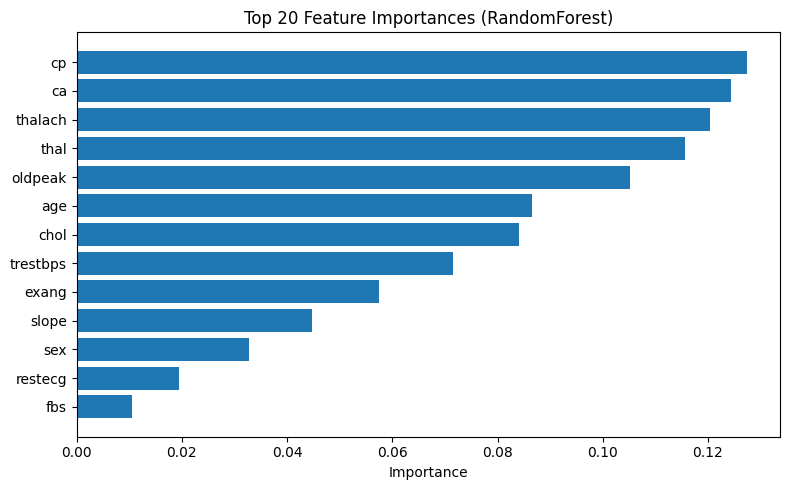


RFE selected features: ['sex', 'cp', 'trestbps', 'fbs', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Chi-square selected features: ['age', 'sex', 'cp', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [4]:
# --- Imports ---
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression

# --- 1. Load and clean the .data file ---
file_path = '../data/heart_disease.data'  # adjust this path
df = pd.read_csv(file_path, header=None)

# Add column names from UCI dataset
df.columns = [
    "age","sex","cp","trestbps","chol","fbs","restecg",
    "thalach","exang","oldpeak","slope","ca","thal","num"
]

# Replace '?' with NaN and convert to numeric
df = df.replace('?', np.nan)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where target ('num') is missing and create binary target
df = df.dropna(subset=['num'])
df['target'] = (df['num'] > 0).astype(int)
df = df.drop(columns=['num'])

print("Shape after cleaning:", df.shape)
print("Target distribution:\n", df['target'].value_counts())

# --- 2. Prepare features and target ---
X = df.drop(columns=['target'])
y = df['target']

# Identify numeric and categorical features
num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = [c for c in X.columns if c not in num_features]

# --- 3. One-hot encoding ---
pre_onehot = ColumnTransformer([
    ("num", "passthrough", num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

X_enc = pre_onehot.fit_transform(X)

# Retrieve feature names
cat_feature_names = []
if cat_features:
    cat_feature_names = list(pre_onehot.named_transformers_['cat'].get_feature_names_out(cat_features))
feature_names = list(num_features) + cat_feature_names

# --- 4. Impute missing values after encoding ---
X_dense = X_enc.toarray() if hasattr(X_enc, "toarray") else X_enc
imputer = SimpleImputer(strategy="median")
X_no_nan = imputer.fit_transform(X_dense)

print("Any NaNs left after imputation?", np.isnan(X_no_nan).any())

# --- 5. RandomForest Feature Importances ---
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_no_nan, y)
importances = rf.feature_importances_

imp_sorted = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:20]
print("\nTop 20 RandomForest Feature Importances:")
for name, val in imp_sorted:
    print(f"{name}: {val:.4f}")

# Plot top 20 feature importances
names, vals = zip(*imp_sorted)
plt.figure(figsize=(8,5))
plt.barh(names[::-1], vals[::-1])
plt.title("Top 20 Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# --- 6. RFE with Logistic Regression ---
lr = LogisticRegression(max_iter=2000)
rfe = RFE(lr, n_features_to_select=min(10, X_no_nan.shape[1]))
rfe.fit(X_no_nan, y)
selected_rfe = [feature_names[i] for i, s in enumerate(rfe.support_) if s]
print("\nRFE selected features:", selected_rfe)

# --- 7. Chi-square Feature Selection ---
scaler = MinMaxScaler()
X_nonneg = scaler.fit_transform(X_no_nan)
chi = SelectKBest(chi2, k=min(10, X_nonneg.shape[1]))
chi.fit(X_nonneg, y)
selected_chi = [feature_names[i] for i in chi.get_support(indices=True)]
print("\nChi-square selected features:", selected_chi)
